#PRETERM BIRTH PHYSIOLOGICAL SIGNAL ANALYSIS

Install required libraries

In [1]:
!pip install wfdb
!pip install kymatio
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 4.1 MB/s eta 0:00:00


Let's import necessary libraries

In [1]:
import os
import wfdb
import numpy as np
import pandas as pd
from kymatio.torch import Scattering1D
import torch
from matplotlib import pyplot as plt
from google.colab import drive

#Load data

We are going to use the waveform database(wfdb) library to load signals from recordings.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


#Understanding our physiological data

In [26]:
main_folder = '/content/drive/My Drive/EHG'

In [27]:
#Classes
os.listdir(main_folder)

['early_cesarean',
 'early_induced',
 'early_induced-cesarean',
 'later_cesarean',
 'later_induced',
 'later_induced-cesarean']

Let's dive into understanding class distribution

In [28]:
data_distribution = os.listdir(main_folder)
for folder in data_distribution:
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))

        print(f"Class: {folder}, Number of files: {num_files}")

Class: early_cesarean, Number of files: 31
Class: early_induced, Number of files: 114
Class: early_induced-cesarean, Number of files: 39
Class: later_cesarean, Number of files: 24
Class: later_induced, Number of files: 129
Class: later_induced-cesarean, Number of files: 39


Class distribution shown graphically

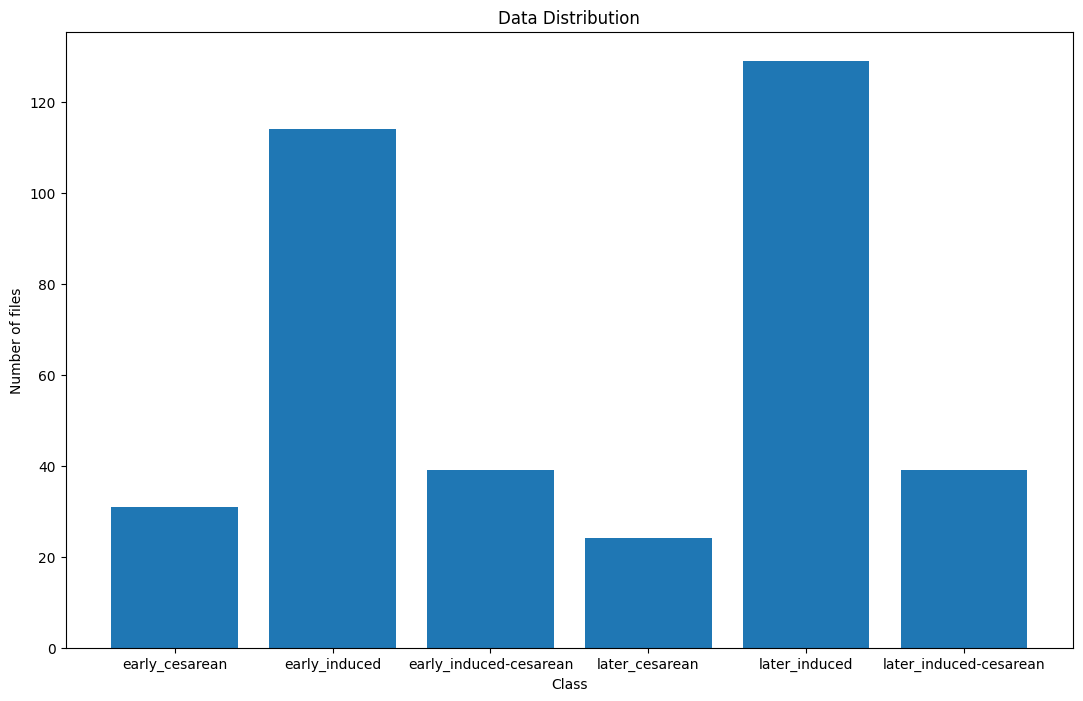

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 8))
plt.bar(data_distribution, [len(os.listdir(os.path.join(main_folder, folder))) for folder in data_distribution] )
plt.xlabel('Class')
plt.ylabel('Number of files')
plt.title('Data Distribution')
plt.show()

#Let's Explore Early Cesarean class

What is inside this class?

In [15]:
early_cesarean_folder = os.path.join(main_folder, 'early_cesarean')
all_files = os.listdir(early_cesarean_folder)
print(all_files[:])

['icehg814.dat', 'icehg666_fltrd.jpg', 'icehg976.dat', 'icehg666.dat', 'icehg885_fltrd.jpg', 'icehg1175_fltrd.jpg', 'icehg885.dat', 'icehg1187.dat', 'icehg657.dat', 'icehg657_fltrd.jpg', 'icehg673_fltrd.jpg', 'icehg1443.dat', 'icehg976_fltrd.jpg', 'icehg673.dat', 'icehg1393_fltrd.jpg', 'icehg1175.dat', 'icehg1089_fltrd.jpg', 'icehg1187_fltrd.jpg', 'icehg814_fltrd.jpg', 'icehg1393.dat', 'icehg1089.dat', 'icehg1443_fltrd.jpg', 'icehg1175.hea', 'icehg673.hea', 'icehg1187.hea', 'icehg885.hea', 'icehg1443.hea', 'icehg976.hea', 'icehg657.hea', 'icehg666.hea', 'icehg1089.hea', 'icehg1393.hea', 'icehg814.hea']


Let's extract the *icehg657.dat* signal for analysis. It is located at the eighth position in the list.

In [23]:
dat_files = [os.path.splitext(f)[0] for f in all_files if f.endswith('.dat')]

record_name = os.path.join(early_cesarean_folder, dat_files[8])

signal_channel = wfdb.rdrecord(record_name)

What are some parameters inside the *icehg657.dat* signal?

In [17]:
parameters = signal_channel.__dict__
for key, value in parameters.items():
    print(f"{key}: {value}")

record_name: icehg1175
n_sig: 6
fs: 20
counter_freq: None
base_counter: None
sig_len: 35240
base_time: None
base_date: None
comments: ['Comments:', 'RecID 1175', 'RecType Cesarean', 'Gestation 39.3', 'Rectime 22.1', 'Age 26', 'Weight 66', 'Placental_position end', 'Height 165', 'Newborn_weight 3300', 'Pair_RecID 1650']
sig_name: ['S1', 'S1_DOCFILT-4-0.08-5', 'S2', 'S2_DOCFILT-4-0.08-5', 'S3', 'S3_DOCFILT-4-0.08-5']
p_signal: [[ 1.79903868e-01  1.52590219e-03  4.59296559e-02  3.81475547e-04
  -8.33142596e-02 -6.86655985e-04]
 [ 1.76317998e-01  1.31990539e-02  4.59296559e-02  3.35698482e-03
  -8.29327840e-02 -6.10360876e-03]
 [ 1.71435111e-01  5.13466087e-02  4.51667048e-02  1.31990539e-02
  -8.01861601e-02 -2.38803693e-02]
 ...
 [ 1.80056458e-02 -1.25123980e-02  3.50957504e-03  5.64583810e-03
  -9.00282292e-03 -7.62951095e-05]
 [ 2.33463035e-02 -1.56404974e-02  4.95918212e-03  6.25619898e-03
  -1.26649882e-02  1.37331197e-03]
 [ 2.63981079e-02 -2.16678111e-02  5.11177234e-03  3.35698482

Comments variable looks interesting to explore further! Can we find something in this variable from all other signals? Let's see!

In [46]:
for folder in data_distribution:
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        print(f"Class: {folder}")
        for file in os.listdir(folder_path):
            if file.endswith('.dat'):
                # Remove the '.dat' extension for reading the base record
                base_name = os.path.join(folder_path, file.replace('.dat', ''))

                # Check existence of both .dat and .hea files
                dat_file = f"{base_name}.dat"
                hea_file = f"{base_name}.hea"

                if os.path.exists(dat_file) and os.path.exists(hea_file):
                    try:
                        # Read the signal
                        record = wfdb.rdrecord(base_name)
                        print(f"File: {file}, Comments: {record.comments}")
                    except Exception as e:
                        print(f"Error reading {file}: {e}")
                else:
                    print(f"Missing .dat or .hea file for base name: {base_name}")
#save the information to

Class: early_cesarean
File: icehg814.dat, Comments: ['Comments:', 'RecID 814', 'RecType Cesarean', 'Gestation 40.7', 'Rectime 23.1', 'Age 31', 'Weight 72', 'Placental_position end', 'Height 160', 'Newborn_weight 3720', 'Pair_RecID 851']
File: icehg976.dat, Comments: ['Comments:', 'RecID 976', 'RecType Cesarean', 'Gestation 40.9', 'Rectime 21.7', 'Age 31', 'Weight 83', 'Placental_position front', 'Height 180', 'Newborn_weight 4050', 'Pair_RecID None']
File: icehg666.dat, Comments: ['Comments:', 'RecID 666', 'RecType Cesarean', 'Gestation 40.7', 'Rectime 22.4', 'Age 32', 'Weight 113', 'Placental_position end', 'Height 170', 'Newborn_weight 4070', 'Pair_RecID None']
File: icehg885.dat, Comments: ['Comments:', 'RecID 885', 'RecType Cesarean', 'Gestation 40.3', 'Rectime 23.3', 'Age 32', 'Weight 67', 'Placental_position end', 'Height 168', 'Newborn_weight 4000', 'Pair_RecID 714']
File: icehg1187.dat, Comments: ['Comments:', 'RecID 1187', 'RecType Cesarean', 'Gestation 39.9', 'Rectime 21.9', 

Seems the comments variable has rich data worth exploring in the subsequent analysis.

#Back to ICEHG657 signal analysis

Let's see how the visualisation of the first channel (n_sig = 0, for n=0,,,5) in the signal looks like!

In [48]:
channel = parameters.get('p_signal')

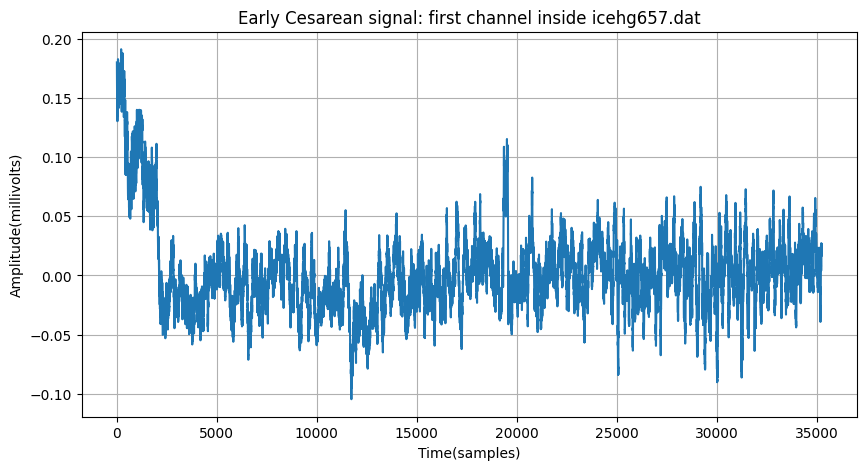

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(channel[:,0], label="Channel 1")
plt.xlabel('Time(samples)')
plt.ylabel('Amplitude(millivolts)')
plt.title('Early Cesarean signal: first channel inside icehg657.dat')
plt.grid(True)
plt.show()

What about the channel? how is it looking like? Let's explore!

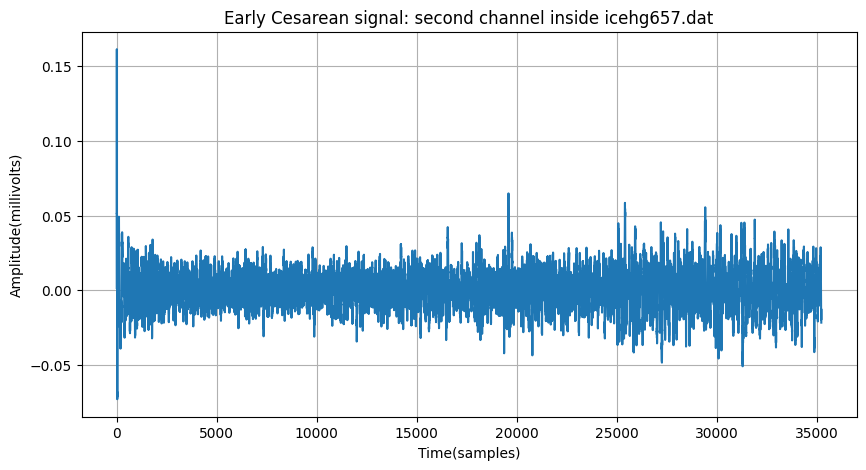

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(channel[:,1], label="Channel 2")
plt.xlabel('Time(samples)')
plt.ylabel('Amplitude(millivolts)')
plt.title('Early Cesarean signal: second channel inside icehg657.dat')
plt.grid(True)
plt.show()

#Frequency analysis

Let's start by exploring the sampling frequency(fs), number of samples taken(sig_len), and units of the signal.

In [65]:
record =  wfdb.rdrecord(record_name)    #This is icehg657.dat recording
print(f"Sampling frequency: {record.fs}")
print(f"Signal length: {record.sig_len}")
print(f"Measurement units used: {record.units[0]}")

Sampling frequency: 20
Signal length: 35240
Measurement units used: mV


Let's use the Fast Fourier Transform(fft) algorithm to decipher frequencies in the signal icehg657 by ploting a spectrum

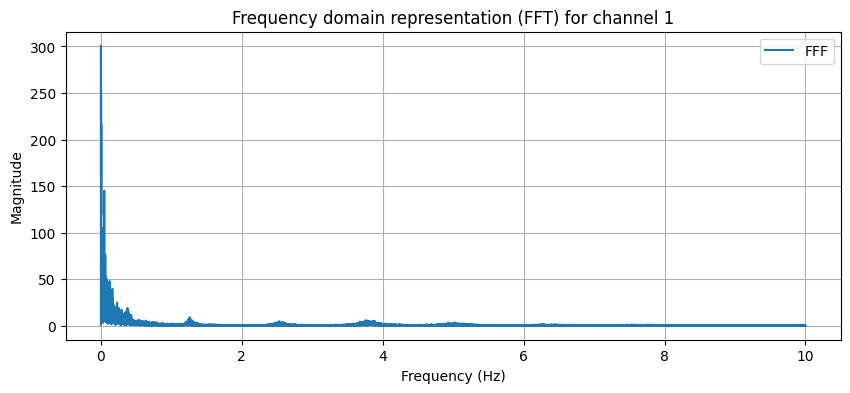

In [66]:
import numpy as np
from scipy.signal import welch

signal_channel_1 = record.p_signal[:, 0]
fs = record.fs

frequencies_fc_1 = np.fft.rfftfreq(len(signal_channel_1), d=1/fs)  #for x-axis
magnitude_fc_1 = np.abs(np.fft.rfft(signal_channel_1))             # for y-axis

# Let's plot a first channel
plt.figure(figsize=(10, 4))
plt.plot(frequencies_fc_1, magnitude_fc_1, label='FFF')
plt.title('Frequency domain representation (FFT) for channel 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()
plt.show()

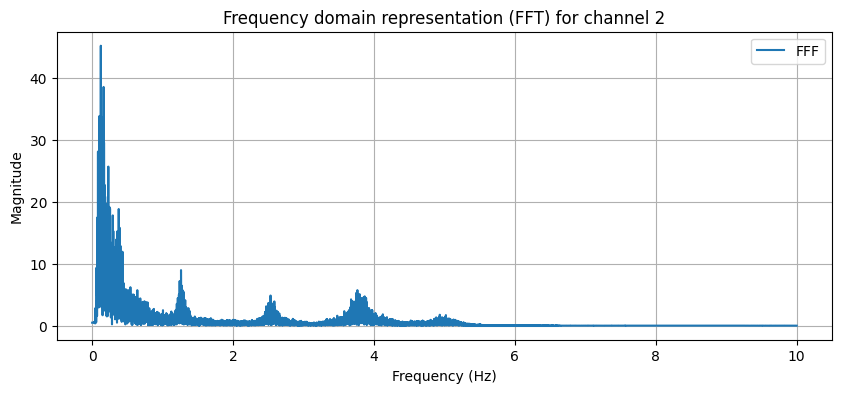

In [68]:
import numpy as np
from scipy.signal import welch

signal_channel_2 = record.p_signal[:, 1]
fs = record.fs

frequencies_fc_2 = np.fft.rfftfreq(len(signal_channel_2), d=1/fs)  #for x-axis
magnitude_fc_2 = np.abs(np.fft.rfft(signal_channel_2))             # for y-axis

# Let's plot a second channel
plt.figure(figsize=(10, 4))
plt.plot(frequencies_fc_2, magnitude_fc_2, label='FFF')
plt.title('Frequency domain representation (FFT) for channel 2')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()
plt.show()


#Power spectral density(PSD)?

This helps understand how the signal's power is distributed across frequencies. The Welch method is commonly used.

We are continuing with signal icehg657 exploration

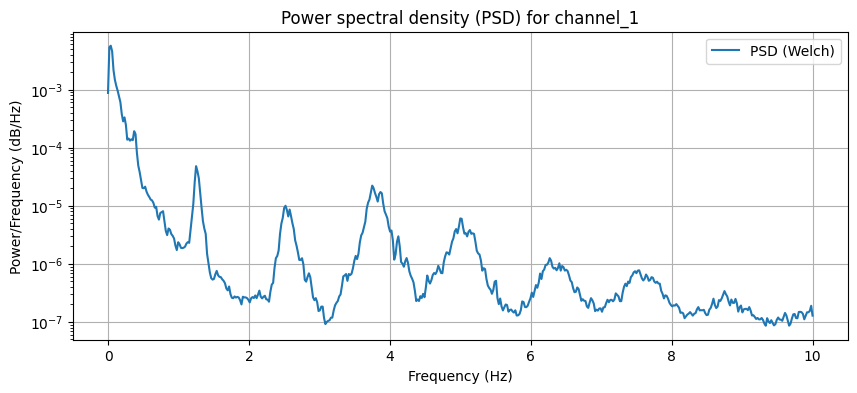

In [69]:
from scipy.signal import welch

frequencies_pf_1, psd_pf_1 = welch(signal_channel_1, fs, nperseg=1024)

# Plot the PSD
plt.figure(figsize=(10, 4))
plt.semilogy(frequencies_pf_1, psd_pf_1, label='PSD (Welch)')
plt.title('Power spectral density (PSD) for channel_1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid()
plt.legend()
plt.show()

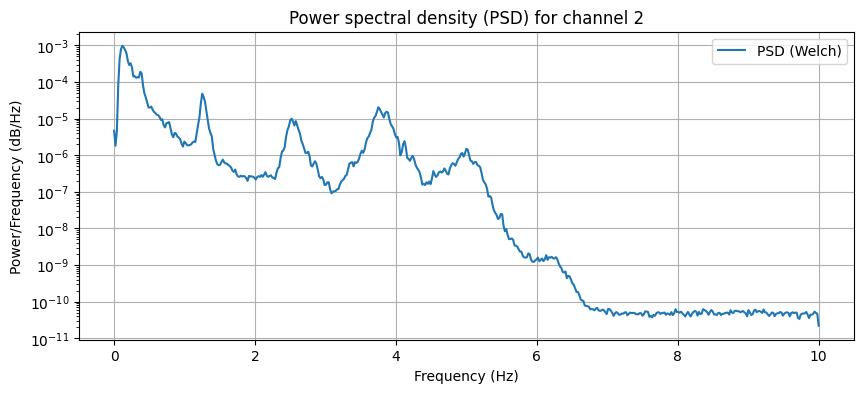

In [70]:
from scipy.signal import welch

frequencies_pf_2, psd_pf_2 = welch(signal_channel_2, fs, nperseg=1024)

# Plot the PSD
plt.figure(figsize=(10, 4))
plt.semilogy(frequencies_pf_2, psd_pf_2, label='PSD (Welch)')
plt.title('Power spectral density (PSD) for channel 2')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid()
plt.legend()
plt.show()

#Let's combine all plots together

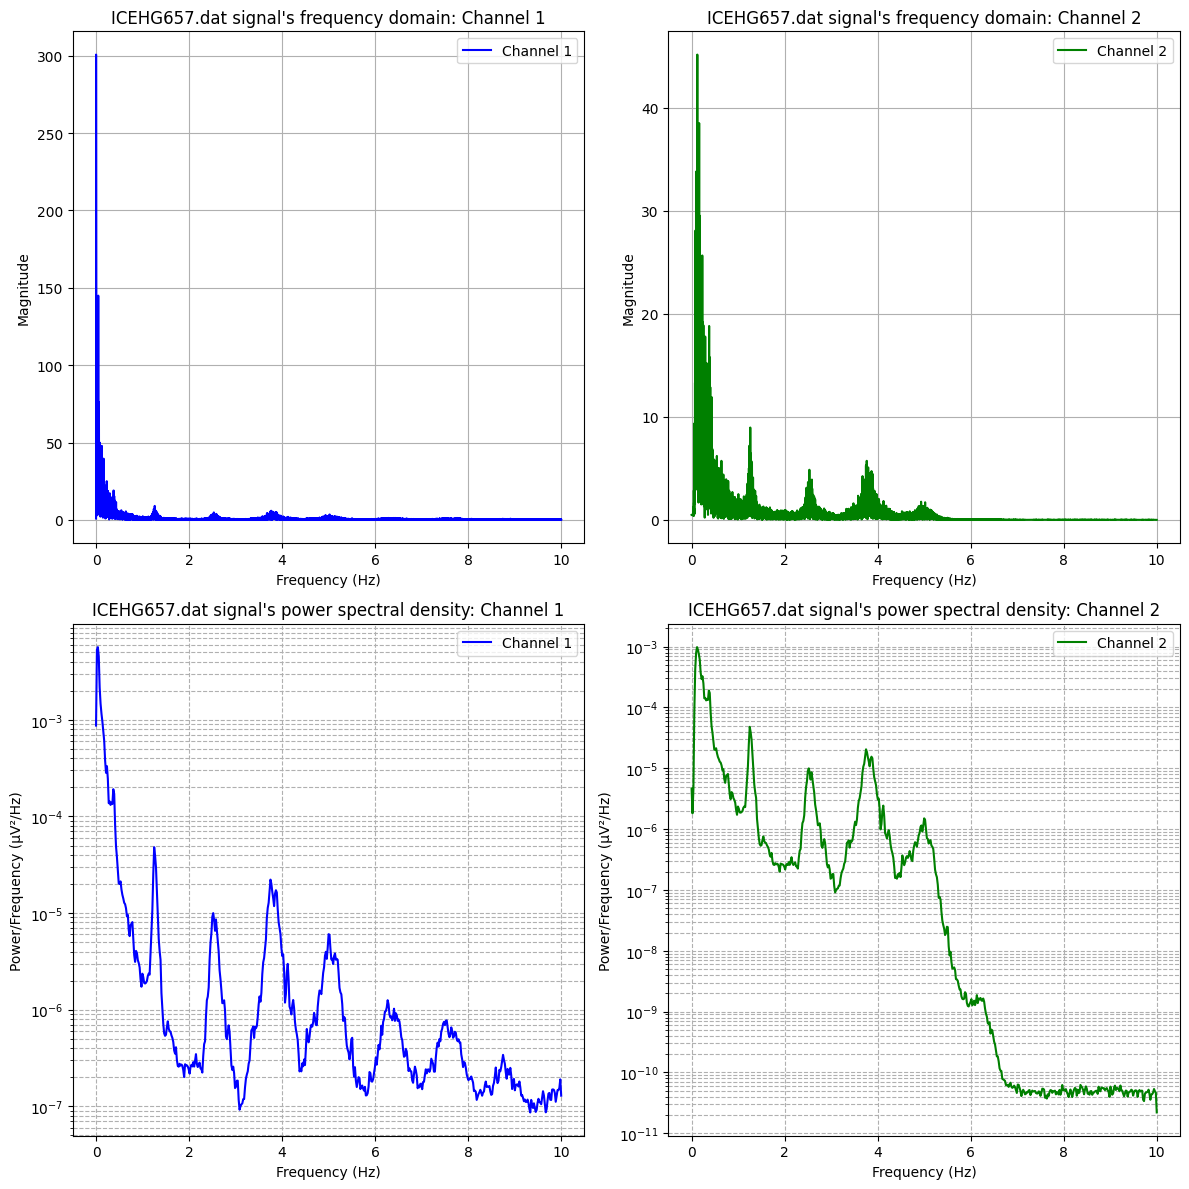

In [71]:
import matplotlib.pyplot as plt

# Create a figure for the subplots
plt.figure(figsize=(12, 12))

# Frequency-domain plot for Channel 1
plt.subplot(2, 2, 1)
plt.plot(frequencies_fc_1, magnitude_fc_1, color="blue", label="Channel 1")
plt.title("ICEHG657.dat signal's frequency domain: Channel 1")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()

# Frequency-domain plot for Channel 2
plt.subplot(2, 2, 2)
plt.plot(frequencies_fc_2, magnitude_fc_2, color="green", label="Channel 2")
plt.title("ICEHG657.dat signal's frequency domain: Channel 2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()

# PSD plot for Channel 1
plt.subplot(2, 2, 3)
plt.semilogy(frequencies_pf_1, psd_pf_1, color="blue", label="Channel 1")
plt.title("ICEHG657.dat signal's power spectral density: Channel 1")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (µV²/Hz)")
plt.grid(True, which="both", linestyle="--")
plt.legend()

# PSD plot for Channel 2
plt.subplot(2, 2, 4)
plt.semilogy(frequencies_pf_2, psd_pf_2, color="green", label="Channel 2")
plt.title("ICEHG657.dat signal's power spectral density: Channel 2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (µV²/Hz)")
plt.grid(True, which="both", linestyle="--")
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


#NOTE: signal in even numbers from the list are filtered signals.

Their names are formated with Sx_DOCFILT-4-0.08-5 in the sig_name paramater. x is for the signal number e.g. 1,2 to 3. Check below

In [72]:
Signalz = record.sig_name
print(Signalz)

['S1', 'S1_DOCFILT-4-0.08-5', 'S2', 'S2_DOCFILT-4-0.08-5', 'S3', 'S3_DOCFILT-4-0.08-5']


Data Source:

Jager, F. (2023). Induced Cesarean EHG DataSet (ICEHG DS): An open dataset with electrohysterogram records of pregnancies ending in induced and cesarean section delivery (version 1.0.1). PhysioNet. https://doi.org/10.13026/zw34-n382.